In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm import tqdm

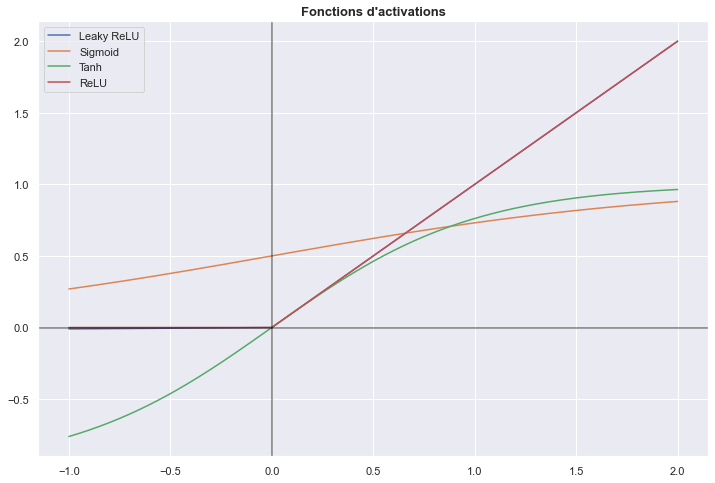

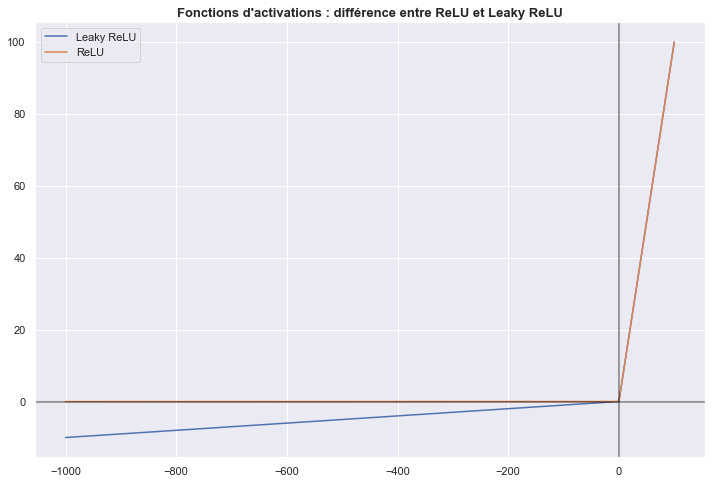

In [6]:
# Activations functions, if deriv parameter = True, computes the derivative of the activation function
def sigmoid(z):
    return 1/(1+np.exp(-z))

def leaky_relu(x, deriv = False):
    if deriv:
        return np.where(x > 0, 1, 0.01)
    else:
        return np.where(x > 0, x, x * 0.01)

def relu(x, deriv = False):
    if deriv:
        return np.where(x > 0, 1, 0)   
    else:
        return np.where(x > 0, x, 0)

def tanh(x, deriv = False):
    if deriv:
        return (1-tanh(x))**2
    else:
        return np.tanh(x)

lr, s, t = list(), list(), list()
il = np.linspace(-1, 2, 1000)
lr = leaky_relu(il)
s = sigmoid(il)
t = tanh(il)
r = relu(il)

plt.figure(figsize = (12, 8))
plt.title('Fonctions d\'activations', fontweight = 'bold', fontsize = 13)
plt.plot(il, lr, label = 'Leaky ReLU')
plt.plot(il, s, label = 'Sigmoid')
plt.plot(il, t, label = 'Tanh')
plt.plot(il,r, label = 'ReLU')
plt.axvline(0, c = 'black', alpha = .5)
plt.axhline(0, c = 'black', alpha = .5)
plt.legend()
plt.show()


lr, s, t = list(), list(), list()
il = np.linspace(-1000, 100, 1000000)
lr = leaky_relu(il)
r = relu(il)

plt.figure(figsize = (12, 8))
plt.title('Fonctions d\'activations : différence entre ReLU et Leaky ReLU', fontweight = 'bold', fontsize = 13)
plt.plot(il, lr, label = 'Leaky ReLU')
plt.plot(il,r, label = 'ReLU')
plt.axvline(0, c = 'black', alpha = .5)
plt.axhline(0, c = 'black', alpha = .5)
plt.legend()
plt.show()

In [3]:
activation = [leaky_relu, leaky_relu, tanh, tanh, sigmoid]
L = len(activation)

In [5]:
def __init_parameters(X, hidden_layers_dims):
    parameters = dict()
    cost_list = list()

    for e in range(len((hidden_layers_dims))):
        # Bias terms
        parameters['b'+str(e+1)] = np.zeros((hidden_layers_dims[e], 1))

        if e == 0:
            # Input Layer
            parameters['W'+str(e+1)] = np.random.randn(hidden_layers_dims[e], X.shape[0])
            parameters['b'+str(e+1)] = np.zeros((hidden_layers_dims[e], 1))
        else:
            # Hidden layers
            parameters['W'+str(e+1)] = np.random.randn(hidden_layers_dims[e], hidden_layers_dims[e-1])
        
    # Output layer
    parameters['W'+str(len(hidden_layers_dims)+1)] = np.random.randn(1, hidden_layers_dims[-1])
    parameters['b'+str(len(hidden_layers_dims)+1)] = np.random.randn(1, 1)
    
    return parameters, cost_list

def __print_dims(parameters):
    for k in parameters.keys():
        print(k,': ', parameters[k].shape)

def forward_propagation(X, activation, parameters, print_suivi=False):
    Z, A = dict(), dict()
    A['0'] = X
    L = len(activation)

    for e in range(L):
        Z[str(e+1)] = (np.dot(parameters['W'+str(e+1)], A[str(e)]) + parameters['b'+str(e+1)])
        A[str(e+1)] = activation[e](Z[str(e+1)])
        if print_suivi == True:
            if L == e+1:
                print('Couche de sortie Ok')
            else:
                print(f'Couche {e+1} Ok')
        
    return Z, A

def compute_cost(pred, Y):
    n = Y.shape[1]
    return - 1/n * np.sum(Y*np.log(pred) + (1-Y)*np.log(1-pred))


def backward_prop(Y, Z, A, print_suivi = False):
    n = Y.shape[1]
    dA, dZ, grads = dict(), dict(), dict()
    for e in reversed(range(1, L+1)): # hidden layers
        
        if e == L: # Cas sigmoid
            # Activation derivatives
            dA[str(e)] =  - np.divide(Y, A[str(e)]) + np.divide(1-Y, 1-A[str(e)])

            # Linear derivatives
            dZ[str(e)] = activation[L-1](Z[str(L)])*(1- activation[L-1](Z[str(L)]))


        else: # Cas non sigmoid for linear derivatives
            dZ[str(e)] = dA[str(e)] * activation[e-1](Z[str(e)], deriv = True)
            
        # Parameters (weights and bias) derivatives for all cases
        grads['dW'+str(e)] = 1/n * np.dot(dZ[str(e)], A[str(e-1)].T)
        grads['db'+str(e)] = 1/n * np.sum(dZ[str(e)], axis = 1, keepdims=1)

        # Activation derivatives for layer l-1
        if e-1 > 0: # We do not compute dA0 because A0 = X
            dA[str(e-1)] = np.dot(grads['dW'+str(e)].T, dZ[str(e)])
        
        if print_suivi:
            print(f'Backward : Couche {e} ok')

    return dA, dZ, grads

alpha = .5
def update(parameters, grads, alpha):
    for e in range(1, L+1):
        parameters['W'+str(e)] = parameters['W'+str(e)] - alpha * grads['dW'+str(e)]
        parameters['b'+str(e)] = parameters['b'+str(e)] - alpha * grads['db'+str(e)]
    
    return parameters

#__print_dims(parameters)
def train(X, Y, activation, iterations):
    parameters, loss = __init_parameters(X, [1024, 68, 32, 10])
    L = len(activation)
    for i in tqdm(range(iterations)):
        Z, A = forward_propagation(X, activation, parameters, print_suivi=False)
        loss.append(compute_cost(A[str(L)], Y))
        _, _, grads = backward_prop(Y, Z, A, print_suivi=False)
        parameters = update(parameters, grads, alpha)

    return loss, parameters